In [455]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import os

csv_file_path = os.path.join(os.getcwd(), 'filtered_data.csv')
data = pd.read_csv(csv_file_path).iloc[::-1]
data['RSI'] = ta.rsi(data['Close'], length=7)
data['EMAF'] = ta.ema(data['Close'], length=14)

data.dropna(inplace=True)
# data = data.drop(data.index[:19])
print(data.head())

    Exchange Date    Close    Net        RSI         EMAF
319    2023-01-26  1093.83  10.70  87.052956  1073.585000
318    2023-01-27  1091.24  -2.59  78.272460  1075.939000
317    2023-01-30  1085.48  -5.76  62.037261  1077.211133
316    2023-01-31  1074.49 -10.99  42.441524  1076.848316
315    2023-02-01  1085.29  10.80  57.744220  1077.973873


## Process data 

In [456]:
data.dropna(inplace=True)
data.set_index('Exchange Date', inplace=True)
print(data.head())

                 Close    Net        RSI         EMAF
Exchange Date                                        
2023-01-26     1093.83  10.70  87.052956  1073.585000
2023-01-27     1091.24  -2.59  78.272460  1075.939000
2023-01-30     1085.48  -5.76  62.037261  1077.211133
2023-01-31     1074.49 -10.99  42.441524  1076.848316
2023-02-01     1085.29  10.80  57.744220  1077.973873


## Scale Data

In [457]:
from sklearn.preprocessing import MinMaxScaler

print(data.head(), end='\n\n')
scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = scaler.fit_transform(data)
print(data_set_scaled[:10])

                 Close    Net        RSI         EMAF
Exchange Date                                        
2023-01-26     1093.83  10.70  87.052956  1073.585000
2023-01-27     1091.24  -2.59  78.272460  1075.939000
2023-01-30     1085.48  -5.76  62.037261  1077.211133
2023-01-31     1074.49 -10.99  42.441524  1076.848316
2023-02-01     1085.29  10.80  57.744220  1077.973873

[[0.84062865 0.70763698 0.98794689 0.76525042]
 [0.82472834 0.42648614 0.86978627 0.78274134]
 [0.78936706 0.35942458 0.65130643 0.79219366]
 [0.72189821 0.24878358 0.38760327 0.78949782]
 [0.78820063 0.70975249 0.59353426 0.79786105]
 [0.79378722 0.50052888 0.60801725 0.80601073]
 [0.74424458 0.31055638 0.44293484 0.80507878]
 [0.60457978 0.         0.18805249 0.78173252]
 [0.60869298 0.49545166 0.20148207 0.76216287]
 [0.63895881 0.58557224 0.30314783 0.7500867 ]]


## Separating data in batches

In [482]:
X = []
# how many data points to look behind at before predicting
# 28 because its the average number of days in a month - can be modified
lookback = 28

# go trough every column 

for j in range(len(data_set_scaled[0])):
    X.append([])
    # go trough every data 
    for i in range(lookback, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-lookback:i, j])
        
X = np.moveaxis(X, [0], [2])
Y = np.array(data_set_scaled[lookback:, -3])
Y = np.reshape(Y, (len(Y), 1))

print(X[:2])
print(Y[:1])

[[[0.84062865 0.70763698 0.98794689 0.76525042]
  [0.82472834 0.42648614 0.86978627 0.78274134]
  [0.78936706 0.35942458 0.65130643 0.79219366]
  [0.72189821 0.24878358 0.38760327 0.78949782]
  [0.78820063 0.70975249 0.59353426 0.79786105]
  [0.79378722 0.50052888 0.60801725 0.80601073]
  [0.74424458 0.31055638 0.44293484 0.80507878]
  [0.60457978 0.         0.18805249 0.78173252]
  [0.60869298 0.49545166 0.20148207 0.76216287]
  [0.63895881 0.58557224 0.30314783 0.7500867 ]
  [0.66443612 0.56907129 0.38402091 0.7437321 ]
  [0.59438885 0.23989846 0.25238102 0.72692083]
  [0.6078949  0.52781891 0.29749547 0.71453062]
  [0.60623734 0.4755659  0.29410419 0.70352494]
  [0.55159924 0.29299767 0.19222685 0.6851694 ]
  [0.58192645 0.5857838  0.30993831 0.67415536]
  [0.51826386 0.26189972 0.19687438 0.65433623]
  [0.55153785 0.59593823 0.31520402 0.64252928]
  [0.48535822 0.25322615 0.20475589 0.62161678]
  [0.41168887 0.22741697 0.11802549 0.59160413]
  [0.44115661 0.58282209 0.21658939 0.57

In [483]:
print(X.shape)
print(Y.shape)

(264, 56, 4)
(264, 1)


## Split data into train test sets

In [484]:
split = int(len(X) * 0.8)
X_train , X_test = X[:split], X[split:]
Y_train , Y_test = Y[:split], Y[split:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(211, 56, 4)
(53, 56, 4)
(211, 1)
(53, 1)


## LSTM Model

In [485]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))
print(keras.__version__)

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
3.3.3


In [532]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

lstm_input = Input(shape=(lookback, len(data_set_scaled[0])), name='lstm_input')
inputs = LSTM(128, name='first_layer', return_sequences=True)(lstm_input)
inputs = Dropout(0.3)(inputs)
inputs = LSTM(64, name='second_layer')(inputs)
inputs = Dropout(0.3)(inputs)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation(keras.activations.leaky_relu, name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=Y_train, batch_size=15, epochs=100, shuffle=True, validation_split=0.1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1040 - val_loss: 0.0421
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0473 - val_loss: 0.0307
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0379 - val_loss: 0.0298
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0380 - val_loss: 0.0310
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0316 - val_loss: 0.0287
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0360 - val_loss: 0.0334
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0349 - val_loss: 0.0281
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0276 - val_loss: 0.0298
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0322 - val_loss: 0.0278
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0278 - val_loss: 0.0278
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0289 - val_loss: 0.0283
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [533]:
from sklearn.metrics import root_mean_squared_error

prediction = model.predict(X_test)
rmse = root_mean_squared_error(Y_test, prediction)

print(rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
0.16523097023769873


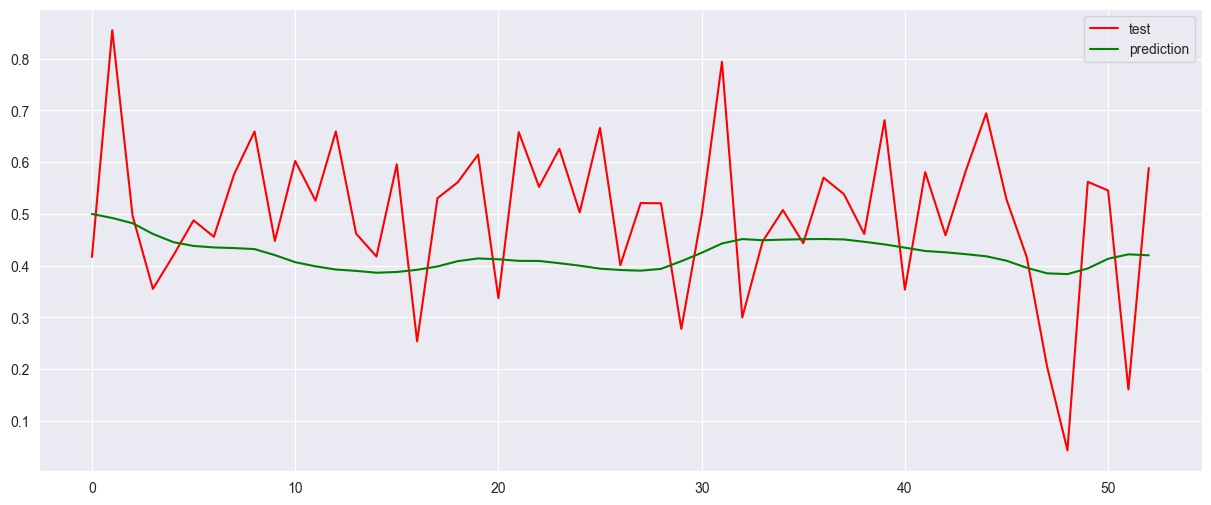

In [534]:
plt.figure(figsize=(15,6))
plt.plot(Y_test, color='red', label='test')
plt.plot(prediction, color='green', label='prediction')
plt.legend()
plt.show()